In [6]:
import gzip
import pickle
import matplotlib.pyplot as plt

# Function to load the datasets

In [7]:
def load_and_unzip_txt_gz(file_path):
    filename ="subset.txt.gz"
    with gzip.open(file_path, 'rt', errors='ignore') as file:
        content = [line.strip() for line in file]
    return content

# Functions to do the Data Cleaning

In [8]:
# Count number of objects and links in the data
def count_objects_and_links(data):
    object_count = 0
    link_count = 0
    for element in data:
        if element.startswith('P'):
            object_count += 1
        elif element.startswith('L'):
            link_count += 1
    return object_count, link_count

#remove lines with more than n=40 links or without any text (Q):
def remove_objects_with_conditions(data):
    new_data = []
    i = 0
    removed_link_count = 0
    removed_no_q_count = 0

    while i < len(data):
        if data[i].startswith('P'):
            link_count = 0
            has_q = False
            j = i + 1
            while j < len(data) and not data[j].startswith('P'):
                if data[j].startswith('L'):
                    link_count += 1
                elif data[j].startswith('Q'):
                    has_q = True
                j += 1
            
            if link_count > 50:
                removed_link_count += 1
            elif not has_q:
                removed_no_q_count += 1
            else:
                new_data.extend(data[i:j])

            i = j
        else:
            i += 1

    return removed_link_count, removed_no_q_count, new_data

#remove links to pages which are not present as P
def remove_links_to_nonexistent_objects(data):
    new_data = []
    object_links = {line.split("\t")[1] for line in data if line.startswith("P")}
    n_removed_objects = 0

    i = 0
    while i < len(data):
        if data[i].startswith('P'):
            new_data.append(data[i])
            j = i + 1
            while j < len(data) and not data[j].startswith('P'):
                if data[j].startswith('L'):
                    link = data[j].split("\t")[1]
                    if link in object_links:
                        new_data.append(data[j])
                    else:
                        n_removed_objects += 1
                else:
                    new_data.append(data[j])
                j += 1
            i = j
        else:
            i += 1

    print(f"Number of removed links to pages outside of the dataset: {n_removed_objects}")
    return new_data

#remove objects without incoming or outgoing link
def remove_nolink_objects(data):
    linked_objects = set()

    for line in data:
        if line.startswith("L"):
            _, link = line.split("\t", 1)
            linked_objects.add(link)

    new_data = []
    current_object = []
    removed_objects_count = 0

    for line in data:
        if line.startswith("P"):
            if current_object:
                if current_object[0].split("\t", 1)[1] in linked_objects:
                    new_data.extend(current_object)
                else:
                    removed_objects_count += 1
            current_object = []
        current_object.append(line)

    if current_object:
        if current_object[0].split("\t", 1)[1] in linked_objects:
            new_data.extend(current_object)
        else:
            removed_objects_count += 1

    print(f"Removed objects without incoming or outgoing link: {removed_objects_count}")
    return new_data

In [9]:
def data_cleaning(data):
    object_count, link_count = count_objects_and_links(data)
    print(f"Number of objects in the list: {object_count}")
    print(f"Total number of links in the list: {link_count}")
    removed_link_count, removed_no_q_count, filtered_data = remove_objects_with_conditions(data)
    print(f"Removed objects with more than 40 links: {removed_link_count}")
    print(f"Removed objects with no 'Q': {removed_no_q_count}")
    filtered_data = remove_links_to_nonexistent_objects(filtered_data)
    filtered_data = remove_nolink_objects(filtered_data)
    return filtered_data

# Load and Clean Data

In [ ]:
# Define a list of filenames
filenames = ['quotes_2008-08.txt.gz', 'quotes_2008-09.txt.gz', 'quotes_2008-10.txt.gz', 'quotes_2008-11.txt.gz', 'quotes_2008-12.txt.gz', 'quotes_2009-01.txt.gz', 'quotes_2009-02.txt.gz', 'quotes_2009-03.txt.gz']

# Define an empty list to store the results
content = []

# Loop through the filenames and process each file
for filename in filenames:
    print(filename)
    result = load_and_unzip_txt_gz(filename)
    # Append the result to the list of results
    result = data_cleaning(result)
    content.append(result)

quotes_2008-08.txt.gz
Number of objects in the list: 7340810
Total number of links in the list: 27819202
Removed objects with more than 40 links: 123658
Removed objects with no 'Q': 2512711
Number of removed links to pages outside of the dataset: 3304977
Removed objects without incoming or outgoing link: 4558956
quotes_2008-09.txt.gz
Number of objects in the list: 9464211
Total number of links in the list: 64387422
Removed objects with more than 40 links: 110099
Removed objects with no 'Q': 4812550
Number of removed links to pages outside of the dataset: 5570874
Removed objects without incoming or outgoing link: 4327657
quotes_2008-10.txt.gz
Number of objects in the list: 10024181
Total number of links in the list: 36700694
Removed objects with more than 40 links: 114201
Removed objects with no 'Q': 5355912
Number of removed links to pages outside of the dataset: 6198301
Removed objects without incoming or outgoing link: 4334483
quotes_2008-11.txt.gz


# Save/load as pickle file

In [ ]:
#flatten the list
content = [item for sublist in content for item in sublist]

# Save the list to a file
with open('content_full.pickle', 'wb') as f:
    pickle.dump(content, f)

In [ ]:
# Load the list from the file
with open('content_full.pickle', 'rb') as f:
    content = pickle.load(f)

In [ ]:
# Count number of objects and links in the data
count_objects_and_links(content)

# Another filtering step: Remove nodes with less than n=8 words in Q(s)

Find reasonable n

In [ ]:
def count_objects(data_list):
    current_object = {"P": "", "T": "", "Q": [], "L": ""}
    count = 0
    for line in data_list:
        if line.startswith('P'):
            # If we already have a current object and it has less than 5 words in its Q attributes, increment the count
            if current_object["P"] and sum(len(q.split()) for q in current_object["Q"]) < 5:
                count += 1
            # start a new object
            current_object = {"P": line[1:].strip(), "T": "", "Q": [], "L": ""}
        elif line.startswith('T'):
            current_object["T"] = line[1:].strip()
        elif line.startswith('Q'):
            current_object["Q"].append(line[1:].strip())
        elif line.startswith('L'):
            current_object["L"] = line[1:].strip()

    # Don't forget the last object
    if current_object["P"] and sum(len(q.split()) for q in current_object["Q"]) < 5:
        count += 1
    
    return count

num_objects = count_objects(content)
num_objects

In [ ]:
def print_objects(data_list):
    current_object = {"P": "", "T": "", "Q": [], "L": ""}
    count = 0
    for line in data_list:
        if line.startswith('P'):
            # If we already have a current object and it has exactly 8 words in its Q attributes, print it
            if current_object["P"] and sum(len(q.split()) for q in current_object["Q"]) == 8:
                print(current_object)
                count += 1
                if count == 8:  # Stop after printing 5 such objects
                    break
            # start a new object
            current_object = {"P": line[1:].strip(), "T": "", "Q": [], "L": ""}
        elif line.startswith('T'):
            current_object["T"] = line[1:].strip()
        elif line.startswith('Q'):
            current_object["Q"].append(line[1:].strip())
        elif line.startswith('L'):
            current_object["L"] = line[1:].strip()

    # Check the last object
    if count < 8 and current_object["P"] and sum(len(q.split()) for q in current_object["Q"]) == 8:
        print(current_object)

print_objects(content)

Filter for n=8

In [ ]:
def filter_q_wordcount(data_list):
    current_object = {"P": "", "T": "", "Q": [], "L": ""}
    object_lines = []
    for line in data_list:
        if line.startswith('P'):
            # If we already have a current object and it has 8 or more words in its Q attributes, add it to the list
            if current_object["P"] and sum(len(q.split()) for q in current_object["Q"]) >= 8:
                object_lines.append(f'P\t{current_object["P"]}')
                if current_object["T"]:
                    object_lines.append(f'T\t{current_object["T"]}')
                for q in current_object["Q"]:
                    object_lines.append(f'Q\t{q}')
                if current_object["L"]:
                    object_lines.append(f'L\t{current_object["L"]}')
            # start a new object
            current_object = {"P": line[2:], "T": "", "Q": [], "L": ""}
        elif line.startswith('T'):
            current_object["T"] = line[2:]
        elif line.startswith('Q'):
            current_object["Q"].append(line[2:])
        elif line.startswith('L'):
            current_object["L"] = line[2:]

    # Don't forget the last object
    if current_object["P"] and sum(len(q.split()) for q in current_object["Q"]) >= 8:
        object_lines.append(f'P\t{current_object["P"]}')
        if current_object["T"]:
            object_lines.append(f'T\t{current_object["T"]}')
        for q in current_object["Q"]:
            object_lines.append(f'Q\t{q}')
        if current_object["L"]:
            object_lines.append(f'L\t{current_object["L"]}')
    
    return object_lines

count_objects_and_links(content)
content = filter_q_wordcount(content)
count_objects_and_links(content)

In [ ]:
# Save the list to a file
with open('content_full.pickle', 'wb') as f:
    pickle.dump(content, f)

In [3]:
# Load the list from the file
with open('content_full.pickle', 'rb') as f:
    content = pickle.load(f)

Filter out memes that have non-english Q(s). Is too computationally intensive to do, so not done.

In [ ]:
"""
from langdetect import detect

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

def filter_non_english_qs(data_list):
    current_object = {"P": "", "T": "", "Q": [], "L": ""}
    object_lines = []
    for line in data_list:
        if line.startswith('P'):
            # Check if all Qs are in English
            all_english = all(is_english(q) for q in current_object["Q"])
            if current_object["P"] and all_english:
                object_lines.append(f'P\t{current_object["P"]}')
                if current_object["T"]:
                    object_lines.append(f'T\t{current_object["T"]}')
                for q in current_object["Q"]:
                    object_lines.append(f'Q\t{q}')
                if current_object["L"]:
                    object_lines.append(f'L\t{current_object["L"]}')
            current_object = {"P": line[2:], "T": "", "Q": [], "L": ""}
        elif line.startswith('T'):
            current_object["T"] = line[2:]
        elif line.startswith('Q'):
            current_object["Q"].append(line[2:])
        elif line.startswith('L'):
            current_object["L"] = line[2:]

    all_english = all(is_english(q) for q in current_object["Q"])
    if current_object["P"] and all_english:
        object_lines.append(f'P\t{current_object["P"]}')
        if current_object["T"]:
            object_lines.append(f'T\t{current_object["T"]}')
        for q in current_object["Q"]:
            object_lines.append(f'Q\t{q}')
        if current_object["L"]:
            object_lines.append(f'L\t{current_object["L"]}')
    
    return object_lines

content = filter_non_english_qs(content)
count_objects_and_links(content)
"""

# Concatenate Q-strings into one big string and perform some NLP analyses

Take substring

In [122]:
def get_substring(big_string, percentage=0.02):
    length = len(big_string)
    substring_length = int(length * percentage)
    return big_string[:substring_length]

substring_4_percent = get_substring(content, 0.02)

for line in substring_4_percent[:7]:
    print(line)

P	http://2under2whoknew.blogspot.com/2008/07/after-that-much-heavy-lets-go-light.html
T	2008-08-01 00:00:13
Q	oh it's an anxiety symptom it will pass
L	http://2under2whoknew.blogspot.com/2008/07/after-that-much-heavy-lets-go-light.html
P	http://smsplus.blogspot.com/2008/08/bagaimana-partai-partai-dapat-uang.html
T	2008-08-01 00:00:30
Q	istilahnya di golkar banyak saudagarnya


### Concatenate

In [128]:
def concatenate_qs(data_list):
    current_object = {"P": "", "T": "", "Q": [], "L": ""}
    all_qs = []
    for line in data_list:
        if line.startswith('P'):
            if current_object["P"]:
                # Add all Qs to the list
                all_qs.extend(current_object["Q"])
            current_object = {"P": line[2:], "T": "", "Q": [], "L": ""}
        elif line.startswith('T'):
            current_object["T"] = line[2:]
        elif line.startswith('Q'):
            current_object["Q"].append(line[2:])
        elif line.startswith('L'):
            current_object["L"] = line[2:]

    # Don't forget the last object
    if current_object["P"]:
        all_qs.extend(current_object["Q"])
    
    # Join all Qs with "::"
    all_qs_string = ".".join(all_qs)
    
    return all_qs_string

conc_string = concatenate_qs(substring_4_percent)

conc_string[0:230]

"oh it's an anxiety symptom it will pass.istilahnya di golkar banyak saudagarnya.para pengusaha menyadari ekonomi tidak boleh dipisahkan dari politik kepentingan bersama kami bangun di sini.golkar akan menggunakan dana halal bukan "

### NLP analysis

In [129]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [130]:
tokens = nltk.word_tokenize(conc_string)
text_obj = nltk.Text(tokens)

text_obj.concordance("Obama")

Displaying 25 of 1574 matches:
o be a lot of energy surrounding the obama campaign and we need to find ways to
sh is mentally handicapped.as barack obama has said rap lyrics too often perpet
 the argument they 're making.barack obama has played the race card and he play
 card has become a permanent part of obama 's hand a wild card to be played whe
wont be part of our campaign.senator obama has continuously attacked me but the
on and they are both reporting on an obama press conference.journalism has to b
ur way out act accordingly.as barack obama has said many many times in the past
lar bills.i 'm disappointed that sen obama would say the things he 's saying.ba
d say the things he 's saying.barack obama has played the race card and he play
be proud of.i respect and admire sen obama we just have stark differences.while
wont be part of our campaign.senator obama has continuously attacked me but the
ll get our 15 minutes of fame barack obama has already had an hour and a half i
es would 

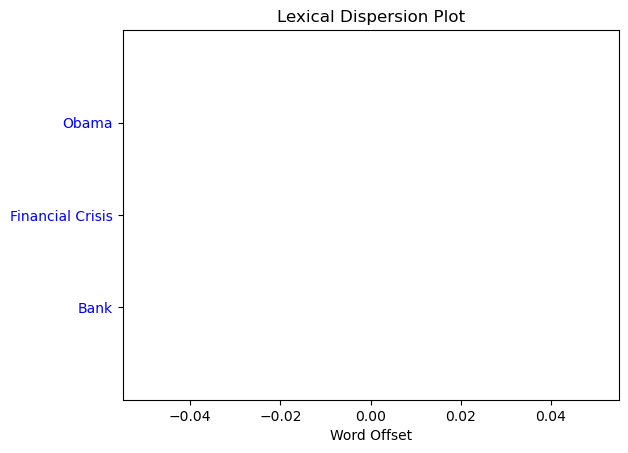

In [79]:
text_obj.dispersion_plot(["Obama", "Financial Crisis", "Bank"])

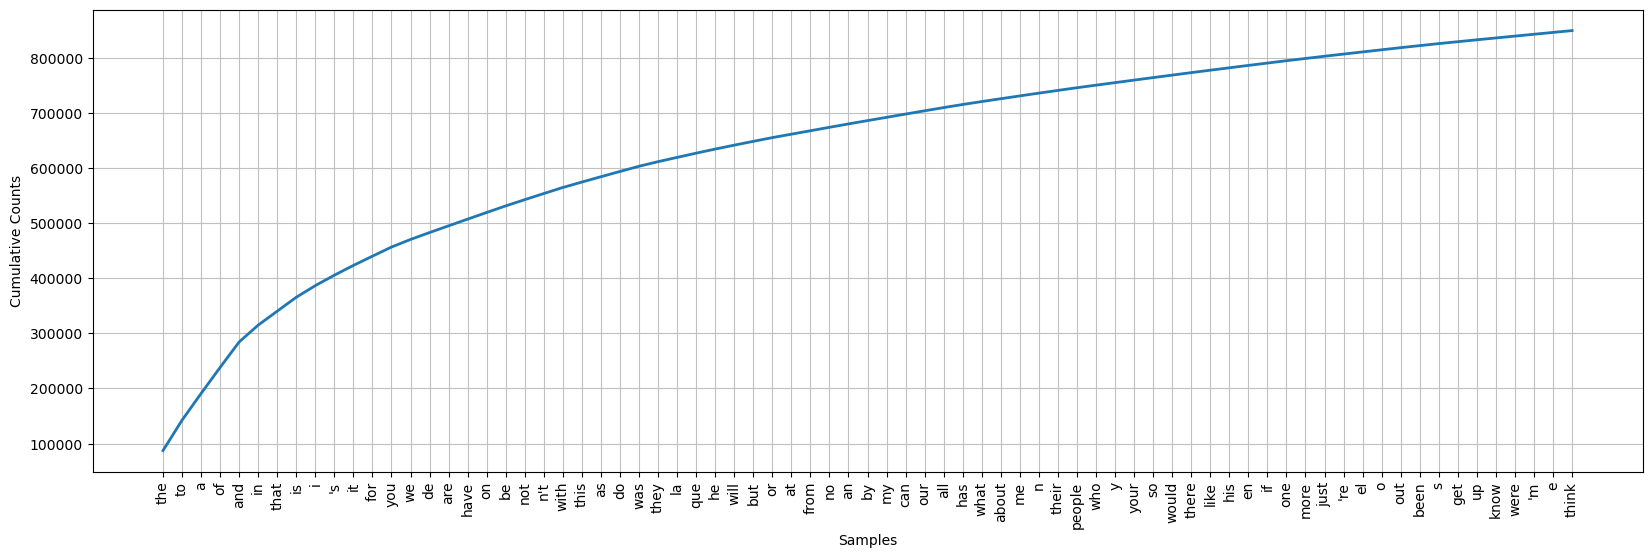

<Axes: xlabel='Samples', ylabel='Cumulative Counts'>

In [131]:
# Create a frequency distribution of the words
fdist = nltk.FreqDist(text_obj)

# Select the 30 most common words
# top_words = fdist.most_common(30)
plt.figure(figsize=(20, 6))  # Increase the width to 20 inches and height to 6 inches

fdist.plot(75, cumulative=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading stopwords-iso: Package 'stopwords-iso' not
[nltk_data]     found in index


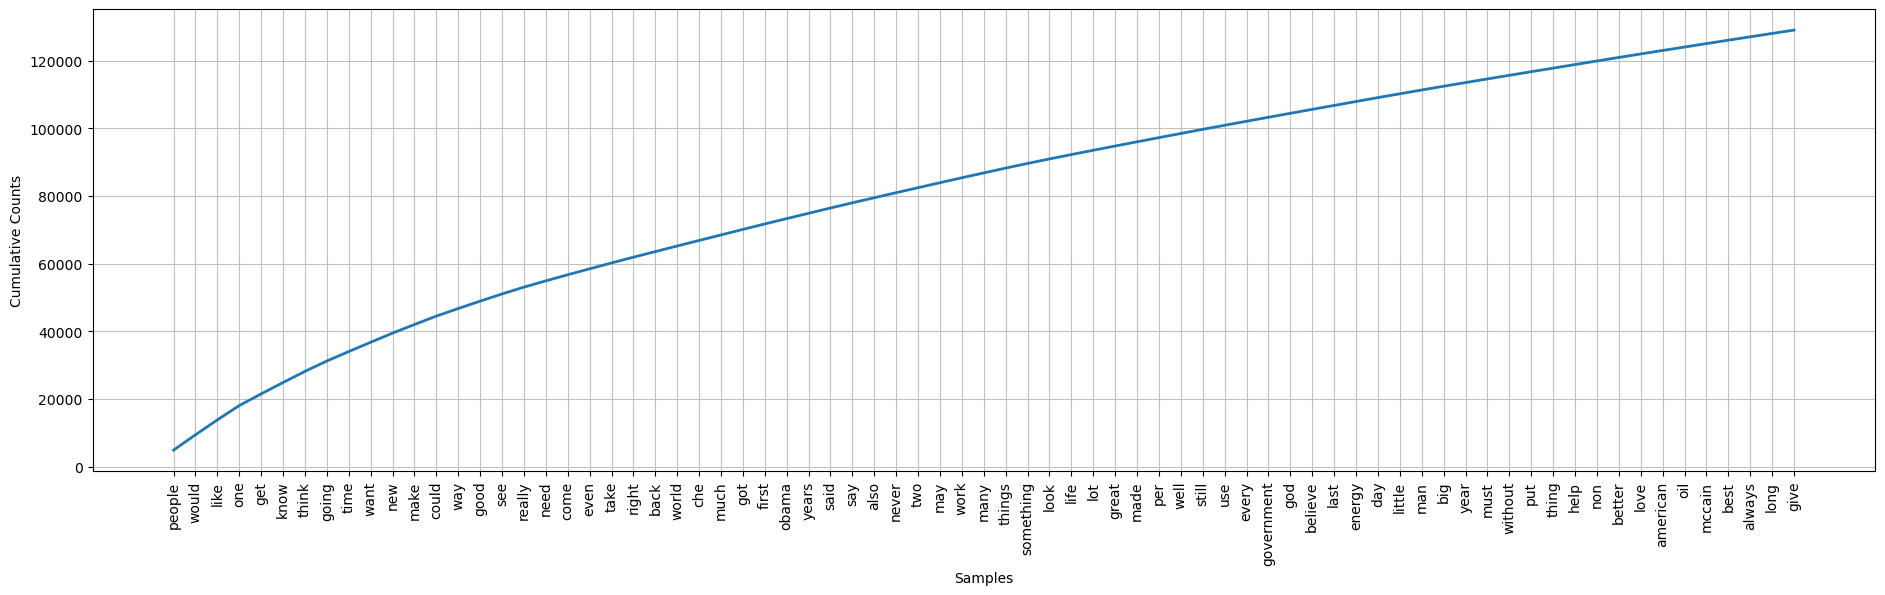

In [132]:
#remove stopwords
# Download the stopwords corpus if not already downloaded
nltk.download('stopwords')
nltk.download('stopwords-iso')

# Load the English, Spanish, and French stopwords
en_stop_words = set(nltk.corpus.stopwords.words('english'))
es_stop_words = set(nltk.corpus.stopwords.words('spanish'))
fr_stop_words = set(nltk.corpus.stopwords.words('french'))

# Combine the stopwords from all three languages
stop_words = en_stop_words.union(es_stop_words, fr_stop_words)

words = [word.lower() for word in tokens if word.lower() not in stop_words and word.isalpha() and len(word) >= 3]
# Create a frequency distribution of the words
fdist = nltk.FreqDist(words)

# Set the size of the figure
plt.figure(figsize=(23, 6))  # Increase the width to 20 inches and height to 6 inches

# Plot the frequency distribution
fdist.plot(75, cumulative=True)

# Show the plot
plt.show()

## Filter for objects where a certain word occurs

In [108]:
def filter_objects_with_word(data_list, target_word):
    current_object = {"P": "", "T": "", "Q": [], "L": ""}
    filtered_objects = []
    for line in data_list:
        if line.startswith('P'):
            if current_object["P"] and any(target_word.strip().lower() in q.strip().lower() for q in current_object["Q"]):
                # If we already have a current object and the target word is in any of its Q attributes, add it to the list
                filtered_objects.append("\n".join(f"{k}\t{v}" for k, v in current_object.items()))
            # start a new object
            current_object = {"P": line[2:], "T": "", "Q": [], "L": ""}
        elif line.startswith('T'):
            current_object["T"] = line[2:]
        elif line.startswith('Q'):
            current_object["Q"].append(line[2:])
        elif line.startswith('L'):
            current_object["L"] = line[2:]

    # Don't forget the last object
    if current_object["P"] and any(target_word.strip().lower() in q.strip().lower() for q in current_object["Q"]):
        filtered_objects.append("\n".join(f"{k}\t{v}" for k, v in current_object.items()))
    
    return filtered_objects


In [133]:
filtered_list = filter_objects_with_word(content, "obama")
conc_string_word_filtered = concatenate_qs(filtered_list)
tokens_word_filtered = nltk.word_tokenize(conc_string_word_filtered)
text_obj_word_filtered = nltk.Text(tokens_word_filtered)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


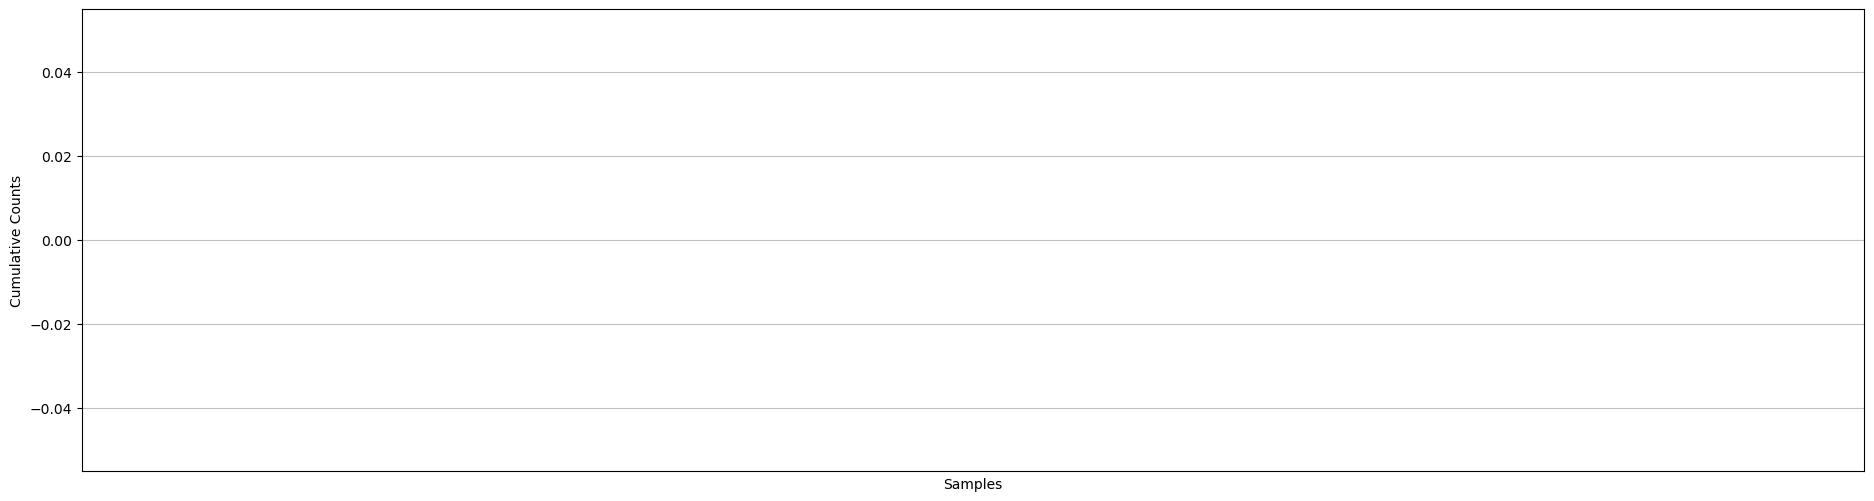

In [134]:
#remove stopwords
# Download the stopwords corpus if not already downloaded
nltk.download('stopwords')
#nltk.download('stopwords-iso')

# Load the English, Spanish, and French stopwords
en_stop_words = set(nltk.corpus.stopwords.words('english'))
es_stop_words = set(nltk.corpus.stopwords.words('spanish'))
fr_stop_words = set(nltk.corpus.stopwords.words('french'))

# Combine the stopwords from all three languages
stop_words = en_stop_words.union(es_stop_words, fr_stop_words)

words = [word.lower() for word in tokens_word_filtered if word.lower() not in stop_words and word.isalpha() and len(word) >= 3]
# Create a frequency distribution of the words
fdist = nltk.FreqDist(words)

# Set the size of the figure
plt.figure(figsize=(23, 6))  # Increase the width to 20 inches and height to 6 inches

# Plot the frequency distribution
fdist.plot(10, cumulative=True)

# Show the plot
plt.show()

In [99]:
filtered_list = filter_objects_with_word(content, "obama")
conc_string_word_filtered = concatenate_qs(filtered_list)
print(conc_string_word_filtered)

In [113]:
#filtered_list = filter_objects_with_word(substring_4_percent, "obama")
filtered_list = filter_objects_with_word(content, "obama")
for line in filtered_list[:20]:
    print(line)

P	http://washtimes.com/news/2008/jul/31/mccain-veep-talk-turns-female-candidates
T	2008-08-01 00:05:00
Q	['if mccain picked a woman it would certainly get the attention and perhaps votes of some democrats and a number of independents who supported hillary clinton', 'sarah palin is a great choice', "she's got it all and is a remarkable leader who brings a number of good qualities to the table", 'one more relatively boring normal mainstream republican white guy', "this fall there's going to be a lot of energy surrounding the obama campaign and we need to find ways to generate a substantial amount of energy around the mccain campaign and an effective dynamic different kind of vice presidential nominee i think would make a difference", 'a mother of five is a genuine alaskan is a hunter is a dogsledder is very much for drilling for oil has a great reform reputation took on big oil on behalf of the people of alaska', 'i think she would bring a level of excitement and uniqueness that people w

In [112]:
conc_string_word_filtered[0:1000]

''

In [102]:
for line in substring_4_percent[:10]:
    print(line)

o
h
 
i
t
'
s
 
a
n
